# Initial Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
import sklearn
import warnings, random, pickle, sys
warnings.filterwarnings("ignore")
sys.path.append('../src/')
from utils import *
plt.style.use("ggplot")

In [2]:
# checking main libraries version
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"scikit-learn=={sklearn.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"matplotlib=={mpl.__version__}")

pandas==1.5.2
numpy==1.23.5
scikit-learn==1.2.1
seaborn==0.11.2
matplotlib==3.5.1


# Prepare Data

In [3]:
# read data
interaction = pd.read_csv("../data/customer_interactions.csv")
product = pd.read_csv("../data/product_details.csv", sep=";")
purchase = pd.read_csv("../data/purchase_history.csv", sep=";")

# drop unnecessary columns
for col in product.columns:
  if col.startswith("Unnamed"):
    product.drop(columns=col, inplace=True)

for col in purchase.columns:
  if col.startswith("Unnamed"):
    purchase.drop(columns=col, inplace=True)

# checking
display(interaction)
display(interaction.info())

display(product)
display(product.info())

display(purchase)
display(purchase.info())

,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  5 non-null      int64
 1   page_views   5 non-null      int64
 2   time_spent   5 non-null      int64
dtypes: int64(3)
memory usage: 248.0 bytes


None

,product_id,category,price,ratings
0,101,Electronics,500,4.5
1,102,Clothing,50,3.8
2,103,Home & Kitchen,200,4.2
3,104,Beauty,30,4.0
4,105,Electronics,800,4.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  5 non-null      int64  
 1   category    5 non-null      object 
 2   price       5 non-null      int64  
 3   ratings     5 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 288.0+ bytes


None

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04
5,5,101,2023-01-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6 non-null      int64 
 1   product_id     6 non-null      int64 
 2   purchase_date  6 non-null      object
dtypes: int64(2), object(1)
memory usage: 272.0+ bytes


None

## Data Exploration

In [4]:
merged_df = pd.merge(
  interaction, 
  purchase, 
  left_on="customer_id", 
  right_on="customer_id", 
  how="outer"
).merge(
  product, 
  left_on="product_id", 
  right_on="product_id", 
  how="outer"
).sort_values(
  ["page_views"]
).reset_index(drop=True)
merged_df

,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.0
1,2,20,90,102,2023-01-02,Clothing,50,3.8
2,5,22,110,101,2023-01-05,Electronics,500,4.5
3,1,25,120,101,2023-01-01,Electronics,500,4.5
4,1,25,120,105,2023-01-05,Electronics,800,4.8
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.2


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    6 non-null      int64  
 1   page_views     6 non-null      int64  
 2   time_spent     6 non-null      int64  
 3   product_id     6 non-null      int64  
 4   purchase_date  6 non-null      object 
 5   category       6 non-null      object 
 6   price          6 non-null      int64  
 7   ratings        6 non-null      float64
dtypes: float64(1), int64(5), object(2)
memory usage: 512.0+ bytes


In [6]:
merged_df.groupby("category").mean()#.corr()#.describe()

,customer_id,page_views,time_spent,product_id,price,ratings
category,,,,,,
Beauty,4.000000,15.0,80.000000,104.000000,30.0,4.0
Clothing,2.000000,20.0,90.000000,102.000000,50.0,3.8
Electronics,2.333333,24.0,116.666667,102.333333,600.0,4.6
Home & Kitchen,3.000000,30.0,150.000000,103.000000,200.0,4.2


In [7]:
# check correlation
display(merged_df.drop(columns=["customer_id", "product_id"]).corr().style.background_gradient())

pd.concat(
  [merged_df.drop(columns=["customer_id", "product_id"]), 
    pd.get_dummies(merged_df["category"])
  ], axis=1
).corr().iloc[:4,4:].style.background_gradient()

,page_views,time_spent,price,ratings
page_views,1.000000,0.978787,0.444448,0.466486
time_spent,0.978787,1.000000,0.414060,0.480461
price,0.444448,0.414060,1.000000,0.973779
ratings,0.466486,0.480461,0.973779,1.000000


,Beauty,Clothing,Electronics,Home & Kitchen
page_views,-0.750202,-0.271350,0.249841,0.686355
time_spent,-0.624716,-0.427437,0.220564,0.756235
price,-0.510171,-0.477949,0.912621,-0.236290
ratings,-0.398527,-0.664211,0.891133,-0.132842


> **Notes**:

- `page_views` and `time_spent` (user features) have very strong correlation
- `price` and `ratings` (item features) have very strong correlation
- user features vs item features have is moderate correlations
- both user features and item features have correlation pattern for every product category

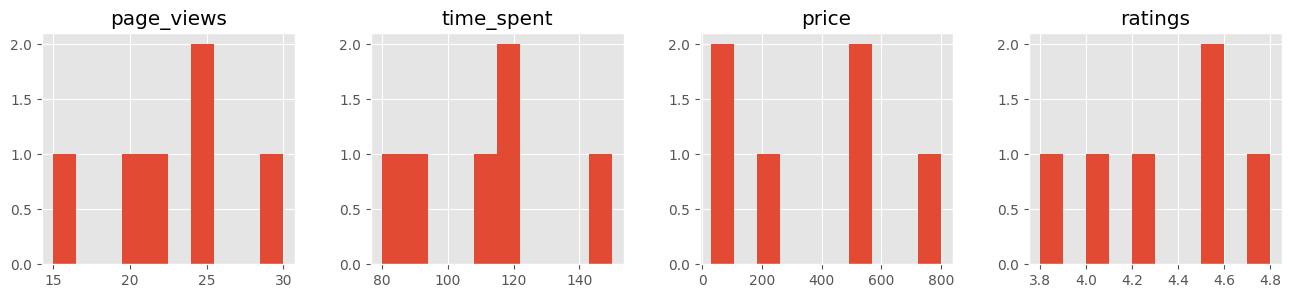

In [8]:
# check data distribution visually
num_cols = [c for c in \
            merged_df.select_dtypes("int64").columns.append(merged_df.select_dtypes("float64").columns) \
            if "id" not in c]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  merged_df[[col]].hist(ax=axes[i])

> **Notes**:

- From given limited data situation (few items per category/product), I'll primarily use **Mean Reciprocal Rank (MRR)** to evaluate our recommendation models. MRR rewards accurate top-ranked recommendations, which is crucial in this scenario.

- I may consider **Mean Average Precision (MAP)** as an additional metric, but its suitability depends on the reliability of the data for MAP calculation.

## Data Augmentation

> **Plan**:

- **Improvement Room**: The initial data distribution appears to be relatively sparse or loose. This might leave room for improvement through data upsampling/augmentation techniques.
- **Upsampling/Augmentation Strategy**: The proposed upsampling approach involves replicating each row N times, followed by adding/subtracting proportionally random values. This method could be effective if the goal is to increase data volume while preserving some level of randomness within each category. However, consider potential drawbacks like introducing artificial correlations and biases.
- **Correlation Check**: Upsampling involves replicating data points, potentially impacting existing correlations. Verifying if upsampled data retains or alters the identified patterns in user-item-category relationships is crucial.

In [9]:
# encode categorical data
le_cat = LabelEncoder()
le_pd = LabelEncoder()
le_cat.fit(merged_df["category"])
le_pd.fit(merged_df["purchase_date"])

LabelEncoder()

In [10]:
merged_df_syn = merged_df.copy()
merged_df_syn["category"] = le_cat.transform(merged_df["category"])
merged_df_syn["purchase_date"] = le_pd.transform(merged_df["purchase_date"])

# Add synthetic data to the DataFrame
N = 4 #1 #3
data_synthetic = pd.concat([add_synthetic_data(merged_df_syn.copy()) for i in range(N)], axis=0)
data_synthetic = generate_new_ids(data_synthetic, "customer_id", 10)
data_synthetic = generate_new_ids(data_synthetic, "product_id", 100)
data_synthetic.reset_index(drop=True, inplace=True)

# Print the original and synthetic data
print("Original data:")
display(merged_df_syn)
print("\nSynthetic data:")
data_synthetic["category"] = data_synthetic["category"].apply(lambda x: le_cat.inverse_transform([x])[0])
data_synthetic["purchase_date"] = data_synthetic["purchase_date"].apply(lambda x: le_pd.inverse_transform([x])[0])
display(data_synthetic.sort_values(["product_id"]))

print("user features correlation (original vs synthetic):")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().iloc[[0,1],4:].style.background_gradient()
)

display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().iloc[[0,1],4:].style.background_gradient()
)
print("\n", "="*60)
print("item features correlation (original vs synthetic):")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().iloc[[2,3],4:].style.background_gradient()
)
display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().iloc[[2,3],4:].style.background_gradient()
)

print("\n", "="*60)
print("all features correlation (original vs synthetic):")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().style.background_gradient()
)
display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().style.background_gradient()
)

Original data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,3,0,30,4.0
1,2,20,90,102,1,1,50,3.8
2,5,22,110,101,4,2,500,4.5
3,1,25,120,101,0,2,500,4.5
4,1,25,120,105,4,2,800,4.8
5,3,30,150,103,2,3,200,4.2



Synthetic data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
5,33,31,153,425,2023-01-03,Home & Kitchen,204,4.27
8,29,26,130,426,2023-01-05,Electronics,590,5.00
20,37,21,106,427,2023-01-05,Electronics,481,4.33
2,20,22,112,428,2023-01-05,Electronics,509,4.58
4,40,25,122,429,2023-01-05,Electronics,814,4.89
22,31,24,115,430,2023-01-05,Electronics,769,4.61
11,25,35,177,431,2023-01-03,Home & Kitchen,236,4.96
19,22,19,87,432,2023-01-02,Clothing,48,3.65
15,27,27,130,433,2023-01-01,Electronics,540,4.86
16,34,27,130,434,2023-01-05,Electronics,863,5.00


user features correlation (original vs synthetic):


,Beauty,Clothing,Electronics,Home & Kitchen
page_views,-0.750202,-0.271350,0.249841,0.686355
time_spent,-0.624716,-0.427437,0.220564,0.756235


,Beauty,Clothing,Electronics,Home & Kitchen
page_views,-0.700309,-0.242681,0.232565,0.630971
time_spent,-0.586702,-0.396187,0.208162,0.703610



item features correlation (original vs synthetic):


,Beauty,Clothing,Electronics,Home & Kitchen
price,-0.510171,-0.477949,0.912621,-0.236290
ratings,-0.398527,-0.664211,0.891133,-0.132842


,Beauty,Clothing,Electronics,Home & Kitchen
price,-0.506476,-0.474412,0.905899,-0.234503
ratings,-0.284726,-0.516180,0.634612,-0.050516



all features correlation (original vs synthetic):


,page_views,time_spent,price,ratings,Beauty,Clothing,Electronics,Home & Kitchen
page_views,1.000000,0.978787,0.444448,0.466486,-0.750202,-0.271350,0.249841,0.686355
time_spent,0.978787,1.000000,0.414060,0.480461,-0.624716,-0.427437,0.220564,0.756235
price,0.444448,0.414060,1.000000,0.973779,-0.510171,-0.477949,0.912621,-0.236290
ratings,0.466486,0.480461,0.973779,1.000000,-0.398527,-0.664211,0.891133,-0.132842
Beauty,-0.750202,-0.624716,-0.510171,-0.398527,1.000000,-0.200000,-0.447214,-0.200000
Clothing,-0.271350,-0.427437,-0.477949,-0.664211,-0.200000,1.000000,-0.447214,-0.200000
Electronics,0.249841,0.220564,0.912621,0.891133,-0.447214,-0.447214,1.000000,-0.447214
Home & Kitchen,0.686355,0.756235,-0.236290,-0.132842,-0.200000,-0.200000,-0.447214,1.000000


,page_views,time_spent,price,ratings,Beauty,Clothing,Electronics,Home & Kitchen
page_views,1.000000,0.978283,0.447682,0.572523,-0.700309,-0.242681,0.232565,0.630971
time_spent,0.978283,1.000000,0.421445,0.586541,-0.586702,-0.396187,0.208162,0.703610
price,0.447682,0.421445,1.000000,0.725366,-0.506476,-0.474412,0.905899,-0.234503
ratings,0.572523,0.586541,0.725366,1.000000,-0.284726,-0.516180,0.634612,-0.050516
Beauty,-0.700309,-0.586702,-0.506476,-0.284726,1.000000,-0.200000,-0.447214,-0.200000
Clothing,-0.242681,-0.396187,-0.474412,-0.516180,-0.200000,1.000000,-0.447214,-0.200000
Electronics,0.232565,0.208162,0.905899,0.634612,-0.447214,-0.447214,1.000000,-0.447214
Home & Kitchen,0.630971,0.703610,-0.234503,-0.050516,-0.200000,-0.200000,-0.447214,1.000000


> **Notes**:

- Synthetic data (upsampling results) can still follow the correlation pattern of the original data.

## Split Data

In [11]:
# get dummy variable to make split can be stratified
y = LabelEncoder().fit_transform(data_synthetic["category"])

# split data
train_set, test_set = train_test_split(data_synthetic, test_size=.25, random_state=42, stratify=y)
train_set.category.value_counts(normalize=True) , test_set.category.value_counts(normalize=True) 

(Electronics       0.500000
 Clothing          0.166667
 Home & Kitchen    0.166667
 Beauty            0.166667
 Name: category, dtype: float64,
 Electronics       0.500000
 Beauty            0.166667
 Clothing          0.166667
 Home & Kitchen    0.166667
 Name: category, dtype: float64)

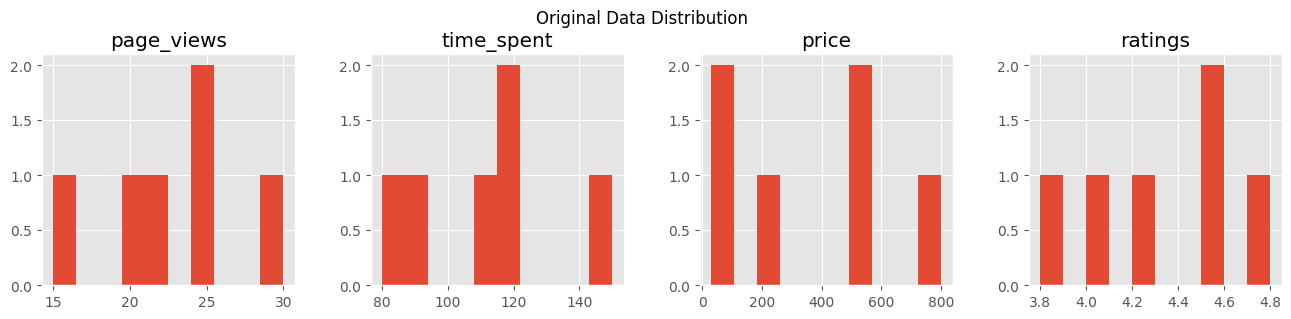

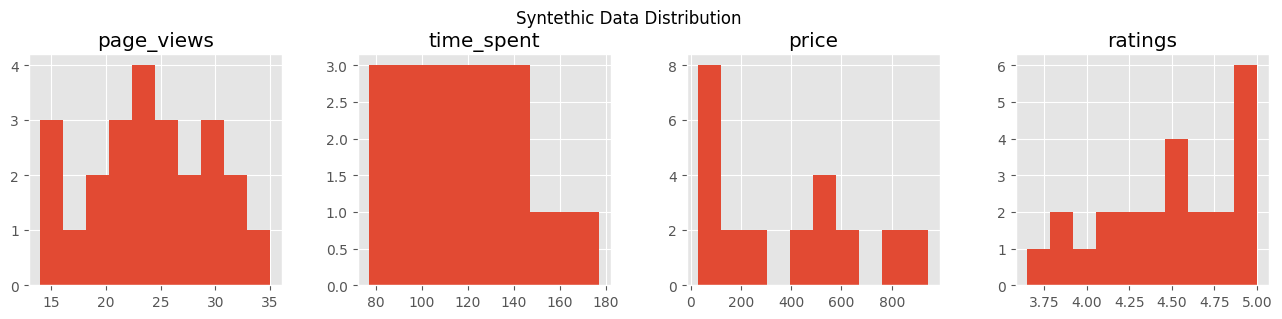

In [12]:
# compare data distribution (original vs synthetic)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  merged_df[[col]].hist(ax=axes[i])
plt.suptitle("Original Data Distribution", y=1.03)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  data_synthetic[[col]].hist(ax=axes[i])
plt.suptitle("Syntethic Data Distribution", y=1.03)
plt.show()

# Modelling

> **Model Development Plan**

- **Exploring User Features for Category Prediction (with varitional items):**
  - The initial model will be a simple K-Nearest Neighbors (KNN) algorithm. This choice is based on the observed correlations between user features and product categories.
  - My main objective is to investigate if and how user features can be leverage to predict the categories of items a user might purchase.
  - I'll start by using the original data and performing manual checks to assess the model's performance. If the results are promising, then proceed to evaluate it with synthetic data.

- **Baseline Comparisons:**
  - To evaluate the KNN model's effectiveness, I'll compare it against two baseline models:
    - **Random:** This model will randomly recommend items from different categories, serving as a benchmark for basic performance.
    - **Highest Rating:** This model will recommend items with the highest rating, representing a simple popularity-based approach.

## Development with Original Data

In [13]:
# user features
user_features = interaction.set_index("customer_id")
scaler = StandardScaler() 
scaler.fit(user_features)
scaled_user_features = pd.DataFrame(scaler.transform(user_features), columns=user_features.columns, index=user_features.index)
print("scaled_user_features:")
display(scaled_user_features)

# bought items as binary features
data = merged_df.copy()
bought_items = data.pivot_table(index="customer_id", columns="product_id", values="category", aggfunc="count").fillna(0)
print("bought_items:")
display(bought_items)

# modelling
k=3
user_idx = {key:val for key,val in enumerate(user_features.index)}
model = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
model.fit(scaled_user_features, bought_items.iloc[:, 0]) 

def get_recommendation_simple(uid: int, k: int = 3) -> tuple[list[int], list[int]]:
  """
  Generates simple recommendations based on collaborative filtering.

  Args:
    uid (int): The user ID for whom to generate recommendations.
    k (int, optional): The number of recommendations to return. Defaults to 3.

  Returns:
    tuple[list[int], list[int]]: A tuple containing two lists:
        - The list of top k most similar user IDs.
        - The list of k recommended item IDs.
  """

  # Prepare input: extract scaled user features for the given user
  input_recsys = scaled_user_features.loc[uid].values

  # Find similar users based on the user features using k-nearest neighbors
  similar_users = model.kneighbors([input_recsys], n_neighbors=k+1, return_distance=False)[0]

  # Recommend items based on frequently bought items by similar users
  rec_items = []
  for idx in similar_users[1:]:  # Exclude the first similar user (the user themself)
    # Find items bought by the similar user
    tmp_item = bought_items.iloc[[idx]].sum(axis=0).sort_values(ascending=False)
    # Filter out items not bought by the user and keep top k recommendations
    tmp_item = list(tmp_item[tmp_item > 0].index)[:k]
    rec_items += tmp_item

  # Remove duplicates and keep top k recommendations
  recommend_items = list(OrderedDict.fromkeys(rec_items))[:k]

  # Map back to real user IDs
  similar_users = [user_idx[i] for i in similar_users]

  return similar_users, recommend_items

# testing
print("merged_df:")
display(merged_df)

print("test recommendation:")
for user_id in range(1,6):
  input_recsys = interaction.set_index("customer_id").loc[user_id].values
  print(user_id, ":", get_recommendation_simple(user_id))

scaled_user_features:


,page_views,time_spent
customer_id,,
1,0.519584,0.408248
2,-0.479616,-0.816497
3,1.518785,1.632993
4,-1.478817,-1.224745
5,-0.079936,0.000000


bought_items:


product_id,101,102,103,104,105
customer_id,,,,,
1,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0


merged_df:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.0
1,2,20,90,102,2023-01-02,Clothing,50,3.8
2,5,22,110,101,2023-01-05,Electronics,500,4.5
3,1,25,120,101,2023-01-01,Electronics,500,4.5
4,1,25,120,105,2023-01-05,Electronics,800,4.8
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.2


test recommendation:
1 : ([1, 5, 2, 3], [101, 102, 103])
2 : ([2, 5, 4, 1], [101, 104, 105])
3 : ([3, 1, 5, 2], [101, 105, 102])
4 : ([4, 2, 5, 1], [102, 101, 105])
5 : ([5, 1, 2, 4], [101, 105, 102])


> **Notes**:  

- The results are still make sense and according to plan. Example in customer_id = 5. The recommendation suggest to buy electronic items, since its features related to user 1 that already bought electronic items. The following recommendation recommend customer to buy clothing, since there is customer_id = 2, that have similar features and already bought clothing item.
- The recommendation item can be improve, to prune the item that user already bough. So that the system actually provides recommendations for new items

## Development with Synthetic Data

In [14]:
# user features
train_data = pd.concat([merged_df, data_synthetic])
train_data.reset_index(drop=True, inplace=True)
new_interaction = train_data.copy()
user_features = new_interaction.groupby(["customer_id"]).agg("mean")[["page_views", "time_spent"]]

# standardize data
scaler_user_features = StandardScaler() 
scaler_user_features.fit(user_features)
scaled_user_features = pd.DataFrame(scaler_user_features.transform(user_features), columns=user_features.columns, index=user_features.index)
print("scaled_user_features (train data):")
display(scaled_user_features)

# bought items as binary 
bought_items = train_data.pivot_table(index="customer_id", columns="product_id", values="category", aggfunc="count").fillna(0)
print("bought_items (train data):")
display(bought_items)

# create dict for interpretation
user_idx = {key:val for key,val in enumerate(user_features.index)}
item_idx = train_data[["product_id","category"]].set_index("product_id").to_dict()["category"]

# modelling
k=5
model = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
model.fit(scaled_user_features, bought_items.iloc[:, 0]) 

# checking
print("train_data:")
display(train_data)

print("recommendation with train data:")
for user_id in user_features.index: 
  print(user_id, ":", get_recommendation(train_data, scaled_user_features, bought_items, model, user_idx, user_id, item_idx))


scaled_user_features (train data):


,page_views,time_spent
customer_id,,
1,0.212519,0.118988
2,-0.721276,-1.044155
3,1.146313,1.282131
4,-1.655071,-1.431869
5,-0.347758,-0.268726
17,1.519831,1.747389
18,-1.841829,-1.548184
19,-0.721276,-0.966612
20,-0.347758,-0.191183


bought_items (train data):


product_id,101,102,103,104,105,425,426,427,428,429,...,439,440,441,442,443,444,445,446,447,448
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


train_data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.00
1,2,20,90,102,2023-01-02,Clothing,50,3.80
2,5,22,110,101,2023-01-05,Electronics,500,4.50
3,1,25,120,101,2023-01-01,Electronics,500,4.50
4,1,25,120,105,2023-01-05,Electronics,800,4.80
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.20
6,23,15,81,438,2023-01-04,Beauty,31,4.07
7,19,20,92,442,2023-01-02,Clothing,51,3.87
8,20,22,112,428,2023-01-05,Electronics,509,4.58
9,32,25,122,444,2023-01-01,Electronics,509,4.58


recommendation with train data:
1 : ([1, 32, 40, 26, 31, 38, 29, 34], [444, 429, 441, 430, 439], ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Electronics'])
2 : ([2, 19, 22, 35, 36, 37, 24, 5], [442, 432, 445, 435, 427], ['Clothing', 'Clothing', 'Beauty', 'Clothing', 'Electronics'])
3 : ([3, 33, 28, 39, 30, 17, 27, 34], [425, 440, 437, 436, 443], ['Home & Kitchen', 'Home & Kitchen', 'Electronics', 'Electronics', 'Home & Kitchen'])
4 : ([4, 23, 18, 24, 35, 22, 2, 19], [438, 448, 447, 445, 432], ['Beauty', 'Beauty', 'Beauty', 'Beauty', 'Clothing'])
5 : ([5, 20, 37, 21, 38, 31, 36, 26], [428, 427, 446, 439, 430], ['Electronics', 'Electronics', 'Clothing', 'Electronics', 'Electronics'])
17 : ([17, 33, 3, 25, 30, 39, 28, 27], [425, 103, 431, 436, 437], ['Home & Kitchen', 'Home & Kitchen', 'Home & Kitchen', 'Electronics', 'Electronics'])
18 : ([18, 4, 23, 24, 35, 22, 2, 19], [104, 438, 447, 445, 432], ['Beauty', 'Beauty', 'Beauty', 'Beauty', 'Clothing'])
19 : ([19, 2, 22, 35

# Model Evaluation

In [15]:
# prepare test data
y_test = test_set[["customer_id","category"]]
y_test.set_index("customer_id", inplace=True)

x_test = test_set.groupby(["customer_id"]).agg("mean")[["page_views", "time_spent"]]
test_data = x_test.merge(y_test, left_index=True, right_index=True)

print("test_set:")
display(test_set)
print("test_data:")
display(test_data)

# prediction 
prediction = {}

# baseline comparation
prediction_random = {}
prediction_top_rating = {}

# make prediction of recommendations
for user_id in test_data.index: 
  
  sim_user, prod_id, cat_item = get_recommendation(train_data, scaled_user_features, bought_items, model, user_idx, user_id, item_idx)
  print(user_id, ":", cat_item)
  
  prediction[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": cat_item
  }

  prediction_random[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": random.sample(list(train_data.category.values), 5)
  }

  prediction_top_rating[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": train_data.sort_values("ratings",ascending=False).category.tolist()[:5]
  }

test_set:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
12,24,16,86,447,2023-01-04,Beauty,32,4.32
13,36,22,97,435,2023-01-02,Clothing,54,4.10
14,26,24,119,441,2023-01-05,Electronics,540,4.86
20,37,21,106,427,2023-01-05,Electronics,481,4.33
4,40,25,122,429,2023-01-05,Electronics,814,4.89
5,33,31,153,425,2023-01-03,Home & Kitchen,204,4.27


test_data:


,page_views,time_spent,category
customer_id,,,
24,16.0,86.0,Beauty
26,24.0,119.0,Electronics
33,31.0,153.0,Home & Kitchen
36,22.0,97.0,Clothing
37,21.0,106.0,Electronics
40,25.0,122.0,Electronics


24 : ['Beauty', 'Beauty', 'Beauty', 'Beauty', 'Clothing']
26 : ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Electronics']
33 : ['Home & Kitchen', 'Home & Kitchen', 'Electronics', 'Electronics', 'Home & Kitchen']
36 : ['Electronics', 'Clothing', 'Clothing', 'Electronics', 'Clothing']
37 : ['Electronics', 'Electronics', 'Clothing', 'Clothing', 'Clothing']
40 : ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Electronics']


{24: {'ground_truth': ['Beauty'],
      'recommendation': ['Beauty', 'Beauty', 'Beauty', 'Beauty', 'Clothing']},
 26: {'ground_truth': ['Electronics'],
      'recommendation': ['Electronics',
                         'Electronics',
                         'Electronics',
                         'Electronics',
                         'Electronics']},
 33: {'ground_truth': ['Home & Kitchen'],
      'recommendation': ['Home & Kitchen',
                         'Home & Kitchen',
                         'Electronics',
                         'Electronics',
                         'Home & Kitchen']},
 36: {'ground_truth': ['Clothing'],
      'recommendation': ['Electronics',
                         'Clothing',
                         'Clothing',
                         'Electronics',
                         'Clothing']},
 37: {'ground_truth': ['Electronics'],
      'recommendation': ['Electronics',
                         'Electronics',
                         'Clothing',
        

,KNN,Random,Top_Rating
MRR,0.9167,0.5833,0.5333
MAP,0.7333,0.2333,0.4333


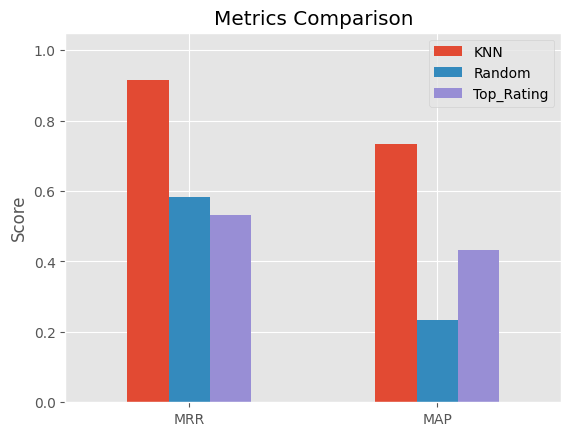

In [19]:
# calculate metrics
metrics = calculate_metrics(prediction)
metrics_pred_random = calculate_metrics(prediction_random)
metrics_pred_top_rating = calculate_metrics(prediction_top_rating)

# convert to df
metrics_df = pd.DataFrame(
  {
    "KNN": metrics,
    "Random": metrics_pred_random,
    "Top_Rating": metrics_pred_top_rating,
    }
)

# show metric's rseult
pprint(prediction)
metrics_df.plot(kind="bar", rot=0)
plt.title("Metrics Comparison")
plt.ylim(0,1.05)
plt.ylabel("Score")
metrics_df.round(4)

> **Notes**:

- With KNN it can outperform the baseline method in all the metrics used. It means the method works and initial results are as planned. The next step is to try the model in production.

# Saving Objects

In [17]:
# choose object to save
pipeline_objects = {
  "model": model,
  "encoder_categories": le_cat,
  "scaler_user_features": scaler_user_features,
  "database": train_data,
  "bought_items": bought_items,
  "scaled_user_features": scaled_user_features,
  "model": model,
  "user_idx": user_idx, 
  "item_idx":item_idx
}

# saving
with open("../pipeline_objects.bin", "wb") as f:
  pickle.dump(pipeline_objects, f)

# test load
with open("../pipeline_objects.bin", "rb") as f:
  loaded_dict = pickle.load(f)

print("Loaded pipeline_objects:", loaded_dict)

Loaded pipeline_objects: {'model': KNeighborsClassifier(metric='euclidean'), 'encoder_categories': LabelEncoder(), 'scaler_user_features': StandardScaler(), 'database':     customer_id  page_views  time_spent  product_id purchase_date  \
0             4          15          80         104    2023-01-04   
1             2          20          90         102    2023-01-02   
2             5          22         110         101    2023-01-05   
3             1          25         120         101    2023-01-01   
4             1          25         120         105    2023-01-05   
5             3          30         150         103    2023-01-03   
6            23          15          81         438    2023-01-04   
7            19          20          92         442    2023-01-02   
8            20          22         112         428    2023-01-05   
9            32          25         122         444    2023-01-01   
10           40          25         122         429    2023-01-05   
11 